### Accessing Data from google drive

In [1]:
!pip install -q gdown

import gdown
import zipfile
import os


file_id = "1-lpracTNUI25VOs4MLyrLnzgP3Lt6HlU"
destination = "data.zip"

gdown.download(f"https://drive.google.com/uc?id={file_id}", destination, quiet=False)


with zipfile.ZipFile(destination, 'r') as zip_ref:
    zip_ref.extractall('./')

os.remove(destination)

Downloading...
From (original): https://drive.google.com/uc?id=1-lpracTNUI25VOs4MLyrLnzgP3Lt6HlU
From (redirected): https://drive.google.com/uc?id=1-lpracTNUI25VOs4MLyrLnzgP3Lt6HlU&confirm=t&uuid=29ffb255-b65e-43e6-9031-12ad211b763e
To: /content/data.zip
100%|██████████| 625M/625M [00:05<00:00, 122MB/s]


### Importing required libraries

In [2]:
import os
import numpy as np
from PIL import Image
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import f1_score, precision_score, recall_score, classification_report, precision_recall_curve
from sklearn.preprocessing import label_binarize, OneHotEncoder
import matplotlib.pyplot as plt

### Feature Engineering functions

In [10]:
def apply_clahe(img):
    img = np.array(img)
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0)
    cl = clahe.apply(l)
    merged = cv2.merge((cl, a, b))
    final = cv2.cvtColor(merged, cv2.COLOR_LAB2RGB)
    return final

In [11]:
def polynomial_transform(img):
    img = np.array(img) / 255.0
    poly = np.clip(img ** 2.2, 0, 1)
    return (poly * 255).astype(np.uint8)

In [12]:
def preprocess_pipeline(img, use_clahe=False, use_poly=False):
    if use_clahe:
        img = apply_clahe(img)
    if use_poly:
        img = polynomial_transform(img)
    return img

### Data generator class

In [13]:
class CustomDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, directory, batch_size, target_size, use_clahe=False, use_poly=False, shuffle=True):
        self.datagen = ImageDataGenerator(rescale=1./255)
        self.generator = self.datagen.flow_from_directory(
            directory,
            target_size=target_size,
            batch_size=batch_size,
            class_mode='categorical',
            shuffle=shuffle
        )
        self.use_clahe = use_clahe
        self.use_poly = use_poly

    def __len__(self):
        return len(self.generator)

    def __getitem__(self, index):
        images, labels = self.generator[index]
        processed_images = np.array([
            preprocess_pipeline((img * 255).astype(np.uint8), self.use_clahe, self.use_poly)
            for img in images
        ])
        processed_images = processed_images / 255.0
        return processed_images, labels

### InceptionV3 model function

In [14]:
def get_inception_model():
    base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    predictions = Dense(2, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

### Training Function

In [15]:
def train_model(name, use_clahe=False, use_poly=False):

    data_dir = '/content/ISIC_image_data'

    train_dir = os.path.join(data_dir, 'Train')
    val_dir = os.path.join(data_dir, 'Val')
    test_dir = os.path.join(data_dir, 'Test')

    train_gen = CustomDataGenerator(train_dir, batch_size=32, target_size=(299, 299), use_clahe=use_clahe, use_poly=use_poly)
    val_gen = CustomDataGenerator(val_dir, batch_size=32, target_size=(299, 299), use_clahe=use_clahe, use_poly=use_poly)
    test_gen = CustomDataGenerator(test_dir, batch_size=32, target_size=(299, 299), use_clahe=use_clahe, use_poly=use_poly, shuffle=False)

    model = get_inception_model()

    checkpoint = ModelCheckpoint(f"best_model_{name}.h5", save_best_only=True, monitor='val_accuracy', mode='max')
    early_stop = EarlyStopping(patience=5, restore_best_weights=True)

    model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=10,
        callbacks=[checkpoint, early_stop]
    )

    loss, acc = model.evaluate(test_gen)
    print(f"Test Accuracy for {name.upper()}: {acc:.4f}")

    y_true = []
    y_pred = []
    y_score = []

    for i in range(len(test_gen)):
        batch_imgs, batch_labels = test_gen[i]
        preds = model.predict(batch_imgs)
        y_true.extend(np.argmax(batch_labels, axis=1))
        y_pred.extend(np.argmax(preds, axis=1))
        y_score.extend(preds)

    y_score = np.array(y_score)
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    target_names = ['Benign', 'Malignant']
    print(f"\nClassification Report for {name.upper()}:")
    print(classification_report(y_true, y_pred, target_names=target_names))

    enc = OneHotEncoder(sparse_output=False, categories='auto')
    y_true_bin = enc.fit_transform(np.array(y_true).reshape(-1, 1))
    if y_true_bin.shape[1] == 1:
      print(f"Only one class present in test set for {name.upper()}. Skipping PR Curve.")
    else:
      plt.figure()
      for i, class_name in enumerate(target_names):
        precision, recall, _ = precision_recall_curve(y_true_bin[:, i], y_score[:, i])
        plt.plot(recall, precision, label=f'{class_name}')
      plt.xlabel('Recall')
      plt.ylabel('Precision')
      plt.title(f'Precision-Recall Curve: {name.upper()}')
      plt.legend(loc='lower left')
      plt.grid(True)
      plt.show()

### Running Model for each variant

Running model for Clahe

Found 2768 images belonging to 2 classes.
Found 664 images belonging to 2 classes.
Found 80 images belonging to 2 classes.
87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 935ms/step - accuracy: 0.7531 - loss: 0.4810

87/87 ━━━━━━━━━━━━━━━━━━━━ 201s 1s/step - accuracy: 0.7537 - loss: 0.4800 - val_accuracy: 0.7575 - val_loss: 0.4633
Epoch 2/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 501ms/step - accuracy: 0.9790 - loss: 0.0750

87/87 ━━━━━━━━━━━━━━━━━━━━ 64s 742ms/step - accuracy: 0.9789 - loss: 0.0751 - val_accuracy: 0.8102 - val_loss: 0.5852
Epoch 3/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 62s 712ms/step - accuracy: 0.9883 - loss: 0.0399 - val_accuracy: 0.7997 - val_loss: 0.8834
Epoch 4/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 530ms/step - accuracy: 0.9960 - loss: 0.0136

87/87 ━━━━━━━━━━━━━━━━━━━━ 66s 757ms/step - accuracy: 0.9960 - loss: 0.0137 - val_accuracy: 0.8599 - val_loss: 0.6344
Epoch 5/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 65s 753ms/step - accuracy: 0.9770 - loss: 0.0775 - val_accuracy: 0.8193 - val_loss: 0.6913
Epoch 6/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 64s 742ms/step - accuracy: 0.9858 - loss: 0.0352 - val_accuracy: 0.8358 - val_loss: 0.7203
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 3s/step - accuracy: 0.8484 - loss: 0.3568
Test Accuracy for CLAHE: 0.8375
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step

Classification Report for CLAHE:
              precision    recall  f1-score   support

      Benign       0.85      0.82      0.84        40
   Malignant       0.83      0.85      0.84        40

    accuracy                           0.84        80
   macro avg       0.84      0.84      0.84        80
weighted avg       0.84      0.84      0.84        80



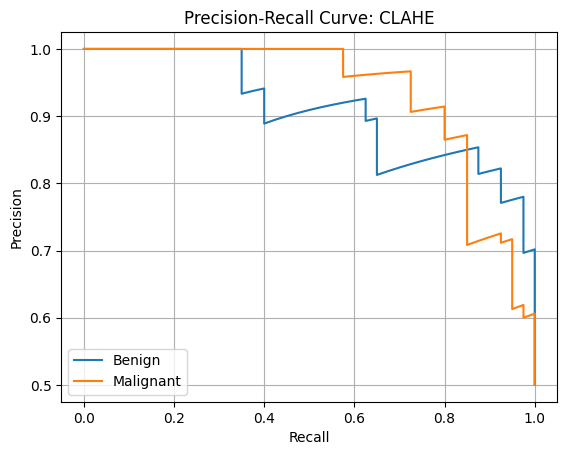

In [16]:
train_model('clahe' ,use_clahe=True)

Running model for Polynomial

Found 2768 images belonging to 2 classes.
Found 664 images belonging to 2 classes.
Found 80 images belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 804ms/step - accuracy: 0.7540 - loss: 0.4845

87/87 ━━━━━━━━━━━━━━━━━━━━ 161s 1s/step - accuracy: 0.7547 - loss: 0.4835 - val_accuracy: 0.8148 - val_loss: 0.4708
Epoch 2/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 545ms/step - accuracy: 0.9640 - loss: 0.0946

87/87 ━━━━━━━━━━━━━━━━━━━━ 69s 788ms/step - accuracy: 0.9640 - loss: 0.0944 - val_accuracy: 0.8630 - val_loss: 0.4326
Epoch 3/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 68s 775ms/step - accuracy: 0.9930 - loss: 0.0281 - val_accuracy: 0.8464 - val_loss: 0.5668
Epoch 4/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 65s 746ms/step - accuracy: 0.9940 - loss: 0.0212 - val_accuracy: 0.8208 - val_loss: 0.9123
Epoch 5/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 64s 740ms/step - accuracy: 0.9962 - loss: 0.0124 - val_accuracy: 0.7530 - val_loss: 1.5454
Epoch 6/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 64s 741ms/step - accuracy: 0.9795 - loss: 0.0623 - val_accuracy: 0.7696 - val_loss: 1.2122
Epoch 7/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 64s 740ms/step - accuracy: 0.9719 - loss: 0.0642 - val_accuracy: 0.7892 - val_loss: 0.9450
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.9016 - loss: 0.1770
Test Accuracy for POLY: 0.8500
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step

Classification Report for

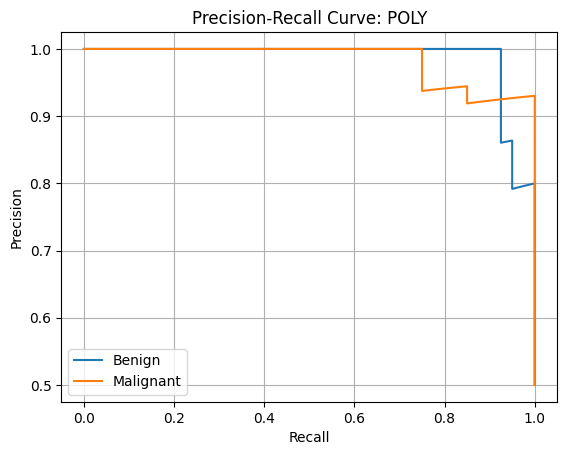

In [17]:
train_model('poly', use_poly=True)

Running model for Polynomial + Clahe

Found 2768 images belonging to 2 classes.
Found 664 images belonging to 2 classes.
Found 80 images belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 855ms/step - accuracy: 0.7360 - loss: 0.5061

87/87 ━━━━━━━━━━━━━━━━━━━━ 167s 1s/step - accuracy: 0.7367 - loss: 0.5051 - val_accuracy: 0.8509 - val_loss: 0.3359
Epoch 2/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 609ms/step - accuracy: 0.9718 - loss: 0.0910

87/87 ━━━━━━━━━━━━━━━━━━━━ 74s 855ms/step - accuracy: 0.9718 - loss: 0.0910 - val_accuracy: 0.8630 - val_loss: 0.4256
Epoch 3/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 597ms/step - accuracy: 0.9891 - loss: 0.0325

87/87 ━━━━━━━━━━━━━━━━━━━━ 73s 835ms/step - accuracy: 0.9892 - loss: 0.0325 - val_accuracy: 0.8675 - val_loss: 0.4296
Epoch 4/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 72s 822ms/step - accuracy: 0.9975 - loss: 0.0115 - val_accuracy: 0.8599 - val_loss: 0.5467
Epoch 5/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 71s 823ms/step - accuracy: 1.0000 - loss: 4.9477e-04 - val_accuracy: 0.8584 - val_loss: 0.5698
Epoch 6/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 72s 828ms/step - accuracy: 1.0000 - loss: 1.5244e-04 - val_accuracy: 0.8630 - val_loss: 0.5674
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - accuracy: 0.8320 - loss: 0.3055
Test Accuracy for CLAHE_POLY: 0.7500


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step

Classification Report for CLAHE_POLY:
              precision    recall  f1-score   support

      Benign       0.67      0.97      0.80        40
   Malignant       0.95      0.53      0.68        40

    accuracy                           0.75        80
   macro avg       0.81      0.75      0.74        80
weighted avg       0.81      0.75      0.74        80



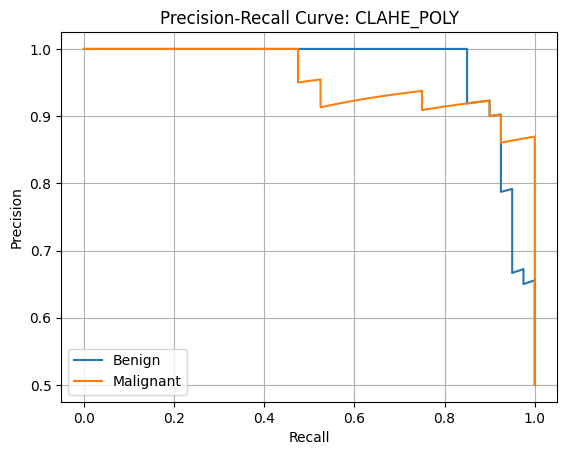

In [18]:
train_model('clahe_poly', use_clahe=True, use_poly=True)

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
Prediction: Benign
Confidence: 0.9989


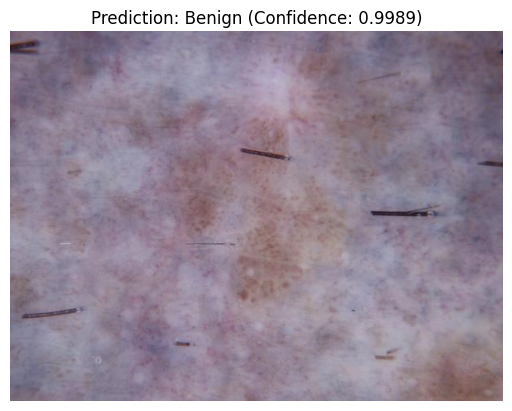

In [19]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import tensorflow as tf

# Load the best model (replace with your actual best model path)
model = tf.keras.models.load_model("best_model_clahe.h5") # Example: using clahe model

# Function to preprocess the image for inference
def preprocess_image(image_path, use_clahe=True, use_poly=False):
    img = Image.open(image_path)
    img = img.resize((299, 299))
    img = np.array(img)
    if use_clahe:
        lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
        l, a, b = cv2.split(lab)
        clahe = cv2.createCLAHE(clipLimit=2.0)
        cl = clahe.apply(l)
        merged = cv2.merge((cl, a, b))
        img = cv2.cvtColor(merged, cv2.COLOR_LAB2RGB)
    if use_poly:
      img = np.array(img) / 255.0
      img = np.clip(img ** 2.2, 0, 1)
      img = (img * 255).astype(np.uint8)
    img = img / 255.0  # Normalize
    img = np.expand_dims(img, axis=0)
    return img

# Example usage:
image_path = "/content/ISIC_image_data/Test/Benign/ISIC_0024446.jpg"

preprocessed_image = preprocess_image(image_path, use_clahe=True) # use_clahe=True because we loaded the clahe model


predictions = model.predict(preprocessed_image)
predicted_class = np.argmax(predictions[0])
confidence = predictions[0][predicted_class]

class_labels = ['Benign', 'Malignant'] # Define class labels


print(f"Prediction: {class_labels[predicted_class]}")
print(f"Confidence: {confidence:.4f}")

# Display the image
img = Image.open(image_path)
plt.imshow(img)
plt.axis('off')
plt.title(f"Prediction: {class_labels[predicted_class]} (Confidence: {confidence:.4f})")
plt.show()